### Napari unwarper - grid of points

In [4]:
import napari
from tifffile import imread
import numpy as np

from pointpats import PointPattern
import matplotlib.pyplot as plt

In [5]:
def generate_perfect_grid(data, 
                          rows,
                          cols,
                          start_margin=.1
                         ):
    '''
    Generates a 2D grid of dots 
    
    Parameters
    ----------
    data : np.array : image
    rows : int : number of rows
    cols : int : number of cols
    start_margin : float : Relative margin at start and end 
    
    Returns
    -------
    grid_dots : np.aray: rows x cols
    
    '''   
    HEIGHT = data.shape[1]
    WIDTH  = data.shape[0]

    HEIGHT_start = HEIGHT * start_margin
    HEIGHT_end   = HEIGHT - (HEIGHT * start_margin)
    WIDTH_start  = WIDTH * start_margin
    WIDTH_end    = WIDTH - (WIDTH * start_margin)
    
    row_pos = np.linspace(HEIGHT_start, HEIGHT_end, num=rows)
    col_pos = np.linspace(WIDTH_start, WIDTH_end,   num=cols)
    
    grid_dots = []
    for y in row_pos:
        for x in col_pos: 
            grid_dots.append([y,x])
    grid_dots = np.vstack(grid_dots)    
    
    return grid_dots

In [6]:
original_tif = '/Volumes/moser/marinaj/PerformanceTests/Ragnhild_Horst_room 2.309/FOV/M009/FOV/AVG_M009_50umgrid_0um_00001.tif'
original_tif_ = imread(original_tif)
print(original_tif_.shape)

(256, 256)


In [7]:
viewer = napari.view_image(original_tif_, rgb=False, name='Grid image')
grid_image_layer = viewer.layers['Grid image']

In [24]:
rows = 9
cols = 9
start_margin = .1

In [9]:
grid_dots = generate_perfect_grid(viewer.layers['Grid image'].data,
                                  rows=rows,
                                  cols=cols,
                                  start_margin=start_margin,
                                 )

In [10]:
viewer.add_points(name='Perfect grid',
                  data=grid_dots,
                  edge_width=1, 
                  edge_color='#000000',  
                  face_color = 'white',
                  opacity = .8,    
                  size=3,
                  blending='translucent'
              )

<Points layer 'Perfect grid' at 0x7f80dc0d3ee0>

In [171]:
#viewer.layers['Perfect grid'].visible = False

In [11]:
viewer.add_points(data=grid_dots.copy(),
                  name='Grid', 
                  edge_width=.4, 
                  edge_color='orangered',  
                  face_color = 'white',
                  opacity = .5,    
                  size=8,
                  blending='translucent'
              )
viewer.layers['Grid'].mode ='select'
viewer.layers['Grid'].symbol ='x'

In [12]:
def unwarp(usr_dots, grid_dots, grid_image_original):
    unwarped = warp_images(
                from_points = usr_dots,
                to_points = grid_dots,
                images = [grid_image_original],
                output_region = [0, 0, grid_image_original.shape[1], grid_image_original.shape[0]],
                interpolation_order=1,
                approximate_grid=1,
                )[0]
    # Check whether margins are free
    col1 = (unwarped[0,:] == 0).all()
    col2 = (unwarped[-1,:] == 0).all()
    row1 = (unwarped[:,0] == 0).all()
    row2 = (unwarped[:,-1] == 0).all()

    status = col1 == col2 == row1 == row2 == True
    return unwarped, status

### Retrieve user dots

In [13]:
import sys
sys.path.append('/Users/hotte/Documents/python/dj-moser-imaging/helpers/')
from mini2p_unwarp import *

In [14]:
layer_grid = viewer.layers['Grid']
usr_dots = layer_grid.data

In [25]:
grid_dots = generate_perfect_grid(viewer.layers['Grid image'].data,
                                  rows=rows,
                                  cols=cols,
                                  start_margin=start_margin
                                  )

In [26]:
grid_image_original = grid_image_layer.data
unwarped, status = unwarp(usr_dots, grid_dots, grid_image_original)

margin_ = start_margin 

if status == True:
    # The image ends up too small or just right
    # Start increasing 
    while status: 
        print(f'Increasing. Margin now at {margin:.1f}')
        margin_+=0.005
        assert margin_ < 2, 'Margin for grid generation >=2 - something went wrong during correction'
        grid_dots_ = generate_perfect_grid(data = grid_image_original,
                                           rows = rows,
                                           cols = cols,
                                           start_margin = margin_,
                                           )
        unwarped, status = unwarp(usr_dots, grid_dots_, grid_image_original)
else:
    # The image ends up too big
    # Start decreasing 
    while not status: 
        print(f'Decreasing. Margin now at {margin:.1f}')
        margin_-=0.005
        assert margin_ > 0, 'Margin for grid generation < 0 - something went wrong during correction'
        grid_dots_ = generate_perfect_grid(data = grid_image_original,
                                           rows = rows,
                                           cols = cols,
                                           start_margin = margin_,
                                           )
        unwarped, status = unwarp(usr_dots, grid_dots_, grid_image_original)

In [28]:
start_margin

0.1

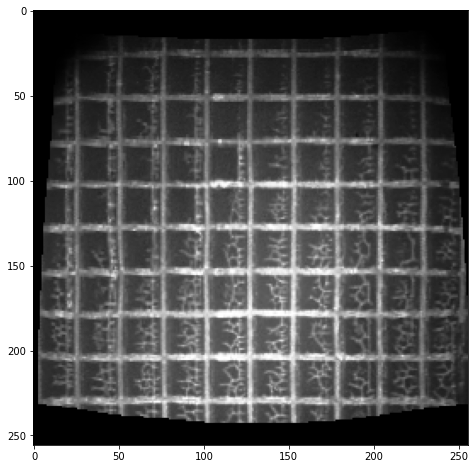

napari has 3 layers


/opt/miniconda3/envs/napari-env/lib/python3.9/site-packages/napari_plugin_engine/manager.py:490: UserWarning: 'No plugin found with the name grid-unwarp'
  warnings.warn(str(e))


In [29]:
#grid_image_original = viewer.layers['Grid image'].data
#grid_image_unwarped = warp(grid_image_original.T, tform, order=4)

figure = plt.figure(figsize=(8,8))
ax = figure.add_subplot(111)
ax.imshow(unwarped, cmap='Greys_r')
#ax.plot(tform.inverse(grid_dots)[:, 0], tform.inverse(grid_dots)[:, 1], '.w')

plt.show()

In [124]:
unwarped.shape

(256, 256)